In [2]:
import numpy as np
import xarray as xr
import pickle
from hyperopt import fmin, hp, Trials, STATUS_OK
from hyperopt import atpe
import minisom
from pathlib import Path
import sys
parent = Path.cwd().parent.resolve()
sys.path.insert(0, str(parent))
from importlib import reload
import SOM_functions as functions
reload(functions)
import warnings
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment
from sklearn.utils import resample
from scipy.stats import theilslopes
import glob
import os
import cftime
np.warnings = warnings
import pandas as pd
from sklearn.utils import resample
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib.lines import Line2D
import pymannkendall as mk
import matplotlib as mpl

/home/users/tildah/nb_envs/SOM_env/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
ERA5_som = functions.load_som('/home/users/tildah/Internship/CIRCULATION/SOMs/ERA5_som_paper_order.pkl')
ERA5_nodes = np.load('/home/users/tildah/Internship/CIRCULATION/SOMs/ERA5_best_nodes_paper_order.npy')
ERA5_HW_zg500_anom = xr.open_dataset('/home/users/tildah/Internship/CIRCULATION/ERA5/ERA5_coords.nc')



In [9]:
def select_latlon(ds):
    ds = ds.drop_vars('number').drop_vars('pressure_level').squeeze('pressure_level')
    ds_coarse = ds.coarsen(latitude=5, longitude=5, boundary="trim").mean()
    return ds_coarse.sel(latitude = slice(90, 20), longitude = slice(-90, 90))

dy = xr.open_mfdataset('/gws/nopw/j04/aopp/tildah/zg_data/ERA5-meanZ500/ERA5_mean_Z500_*.nc', 
                       combine='by_coords',  
                       preprocess=select_latlon)

dy = dy.rename({
    "longitude": "lon",
    "latitude": "lat",
    "valid_time": "time",
    "z": "zg500"
})

zg500raw = dy.isel(time=dy['time'].dt.month.isin([6, 7, 8])).sel(time=slice('1940-06-01', '2014-08-31'))['zg500']
climatology = zg500raw.sel(time=slice("1981-06-01", "2010-08-31")).groupby("time.dayofyear").mean(dim="time")
zg500_anom = zg500raw.groupby("time.dayofyear") - climatology


# Flatten and convert to numpy
zg_daily_flat = zg500_anom.stack(point=["lat", "lon"]).values  # shape: (time, space)
print(zg_daily_flat.shape)

# Extract SOM patterns from MiniSom
som_weights = ERA5_som.get_weights()  # shape: (nx, ny, lat, lon)  

(6900, 8064)


In [10]:
time_array = pd.to_datetime(zg500_anom.time.values)
hw_times = pd.to_datetime(ERA5_HW_zg500_anom.time.values)
hw_mask = np.isin(time_array, hw_times)  

In [23]:
nx, ny, space = som_weights.shape
som_flat = som_weights.reshape(nx*ny, space)  # shape: (n_nodes, space)
print(som_flat.shape)

# Function to compute Pearson correlation (numpy arrays only)
def pattern_correlation(daily, nodes):
    n_time = daily.shape[0]
    n_nodes = nodes.shape[0]
    corr = np.empty((n_time, n_nodes))
    
    for t in range(n_time):
        for n in range(n_nodes):
            corr[t, n], _ = pearsonr(daily[t], nodes[n])  # ignore p-value
    
    return corr

# Compute correlations
correlations = pattern_correlation(zg_daily_flat, som_flat)
print("Correlations shape:", correlations.shape)  # (time, n_nodes)
#print(correlations[hw_mask])

best_node_idx = np.argmax(correlations, axis=1)           # shape: (time,)
print(best_node_idx)
best_node_corr = correlations[np.arange(correlations.shape[0]), best_node_idx]
print(max(best_node_corr[hw_mask]))

weighted_data = functions.weight_data(zg_daily_flat, ERA5_HW_zg500_anom)
# zg_daily_flat should be shape (n_days, dim) and same ordering/flattening as weights
dists = np.linalg.norm(weighted_data[:, None, :] - som_flat[None, :, :], axis=2)  # (n_days, n_nodes)
# best node indices (flat indices in same order as som_flat)
best_node_idx_euc = np.argmin(dists, axis=1)  # shape (n_days,)
best_node_dist_euc = dists[np.arange(dists.shape[0]), best_node_idx_euc]

(4, 8064)
Correlations shape: (6900, 4)
[1 1 1 ... 0 0 0]
0.7583054480648559


In [25]:
# SAVE RESULTS HERE!
times = zg500_anom['time'].values
times = pd.to_datetime([str(t) for t in times])

N_total = best_node_idx.size
if times.size != N_total:
    raise ValueError(f"Length mismatch: times ({times.size}) vs arrays ({N_total}).")

# --- 3. Build the xarray Dataset ---
tds = xr.Dataset(
    data_vars=dict(
        best_node_idx      = ("time", best_node_idx.astype(np.int32)),
        best_node_corr     = ("time", best_node_corr.astype(np.float32)),
        best_node_idx_euc  = ("time", best_node_idx_euc.astype(np.int32)),
        best_node_dist_euc = ("time", best_node_dist_euc.astype(np.float32)),
    ),
    coords=dict(
        time=("time", times),
    ),
    attrs=dict(
        description=f"ERA5: SOM assignments & distances for each ensemble member concatenated along time.",
    )
)

# --- 4. Save to NetCDF ---
out_nc = f"node_assignments/ERA5_node_assignments.nc"
tds.to_netcdf(out_nc)
print(f"✅ Saved dataset to {out_nc}")


✅ Saved dataset to node_assignments/ERA5_node_assignments.nc


In [14]:
# Apply threshold: set node to NaN if poor correlation
threshold = 0.4
best_node_idx_filtered = np.where(best_node_corr >= threshold, best_node_idx, np.nan)

# Combine into a list of tuples (best_node or NaN, correlation)
best_nodes_list = list(zip(best_node_idx_filtered, best_node_corr))
#print(best_node_idx[hw_mask][-10:])

# Example output for the first 5 days
#print(best_nodes_list)

In [15]:
print(ERA5_nodes[:20])
print(best_node_idx[hw_mask][:20])
print(correlations[hw_mask][:20])

similarity = np.mean(ERA5_nodes == best_node_idx[hw_mask]) * 100
print(f"Percentage similarity: {similarity:.2f}%")

[3 3 1 1 1 1 0 1 0 0 0 0 0 0 2 2 3 3 3 3]
[3 3 1 1 1 1 0 1 0 0 0 0 0 1 2 2 3 3 3 3]
[[-0.21601484  0.0443895   0.15859373  0.36872823]
 [-0.21826409  0.16427194  0.02096502  0.25830971]
 [ 0.16650488  0.36758338 -0.24231612  0.02696024]
 [ 0.3196177   0.56930257 -0.15948677 -0.4056156 ]
 [ 0.38543985  0.58455169 -0.2254995  -0.39539217]
 [ 0.4647062   0.54879165 -0.14943242 -0.29132926]
 [ 0.51469997  0.41857638 -0.21963281 -0.19719986]
 [ 0.45440812  0.53046613 -0.1763361   0.07290452]
 [ 0.4908956   0.45663537 -0.13431832  0.17407269]
 [ 0.52181759  0.39751315 -0.09295544  0.09064668]
 [ 0.61607088  0.45942975 -0.01130819 -0.0486949 ]
 [ 0.65394019  0.45537191  0.10418488 -0.0068778 ]
 [ 0.62022045  0.32526972  0.19691794  0.09969691]
 [ 0.49068709  0.49272283  0.47123813 -0.12452879]
 [ 0.3163988   0.34245045  0.51495909  0.01885986]
 [ 0.20218085  0.06007673  0.450604    0.13284494]
 [-0.23397181 -0.4959477  -0.25671285  0.55106474]
 [-0.14765213 -0.39983962 -0.17858157  0.65094608

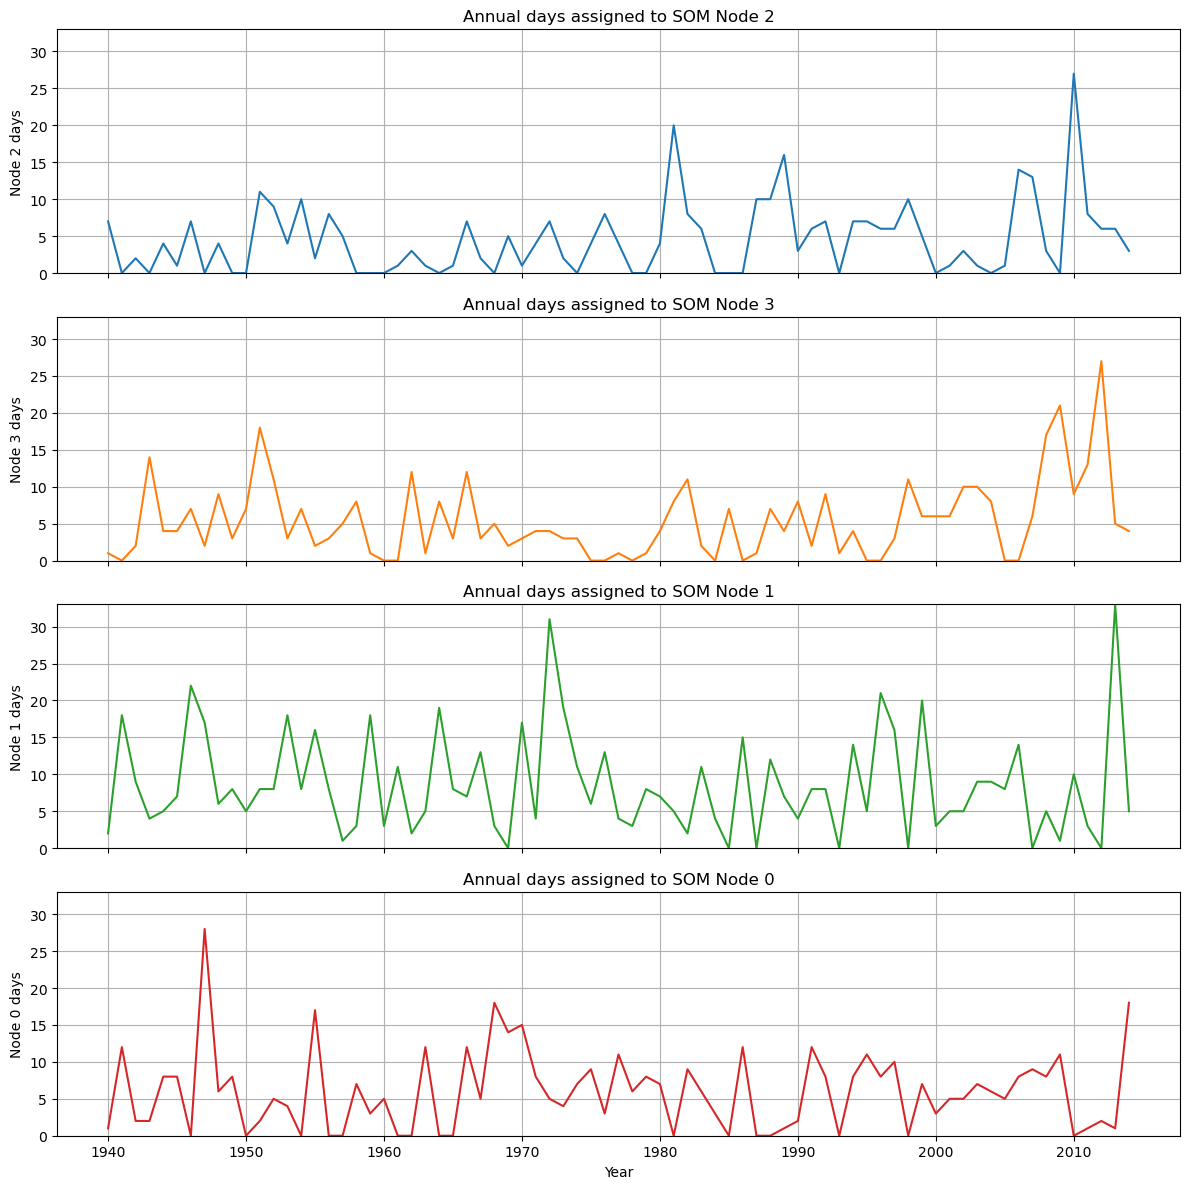

best_node   0   1   2   3
year                     
1940        1   2   7   1
1941       12  18   0   0
1942        2   9   2   2
1943        2   4   0  14
1944        8   5   4   4
...        ..  ..  ..  ..
2010        0  10  27   9
2011        1   3   8  13
2012        2   0   6  27
2013        1  33   6   5
2014       18   5   3   4

[75 rows x 4 columns]


In [16]:
node_order = [2, 3, 1, 0]
# Convert best_nodes_list to DataFrame
best_nodes_idx, best_node_corr = zip(*best_nodes_list)
df = pd.DataFrame({
    "time": time_array,
    "best_node": best_nodes_idx,
    "corr": best_node_corr
})

# Filter out NaN nodes
df_valid = df.dropna(subset=["best_node"]).copy()
df_valid["best_node"] = df_valid["best_node"].astype(int)

# Add year column
df_valid["year"] = df_valid["time"].dt.year

# Count days per node per year
annual_counts = df_valid.groupby(["year", "best_node"]).size().unstack(fill_value=0)

# Determine y-axis limit across all nodes
y_max = annual_counts[node_order].values.max()  # maximum value across reordered nodes

# Plot each node in a separate subplot, in specified order
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

for i, node in enumerate(node_order):
    axes[i].plot(annual_counts.index, annual_counts[node], color=f"C{i}")
    axes[i].set_ylabel(f"Node {node} days")
    axes[i].set_ylim(0, y_max)  # same y-axis scale
    axes[i].grid(True)
    axes[i].set_title(f"Annual days assigned to SOM Node {node}")

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

print(annual_counts)

In [17]:
window = 5
annual_counts_smoothed = annual_counts.rolling(window=window, center=True, min_periods=1).mean()

# Periods
periods = { 
    "1940-1979": (1940, 1979),
    "1980-2014": (1980, 2014)
}

nodes = annual_counts.columns  # 0,1,2,3

results = []

for node in nodes:
    for period_name, (start_year, end_year) in periods.items():
        # Subset years
        df_period = annual_counts_smoothed.loc[(annual_counts_smoothed.index >= start_year) &
                                               (annual_counts_smoothed.index <= end_year), node]
        x = df_period.index.values
        y = df_period.values
        
        if len(y) > 0:
            slope, _, _, _ = theilslopes(y, x)
            slope_decade = slope * 10  # days/decade
            
            # Mann-Kendall significance
            mk_result = mk.original_test(y)
            sig = mk_result.p < 0.05
            
            results.append({
                "Node": node,
                "Period": period_name,
                "Slope_days_per_decade": slope_decade,
                "Significant": sig
            })

# Convert to DataFrame
trend_table = pd.DataFrame(results)
trend_table_pivot = trend_table.pivot(index="Node", columns="Period", values="Slope_days_per_decade")
sig_table_pivot   = trend_table.pivot(index="Node", columns="Period", values="Significant")


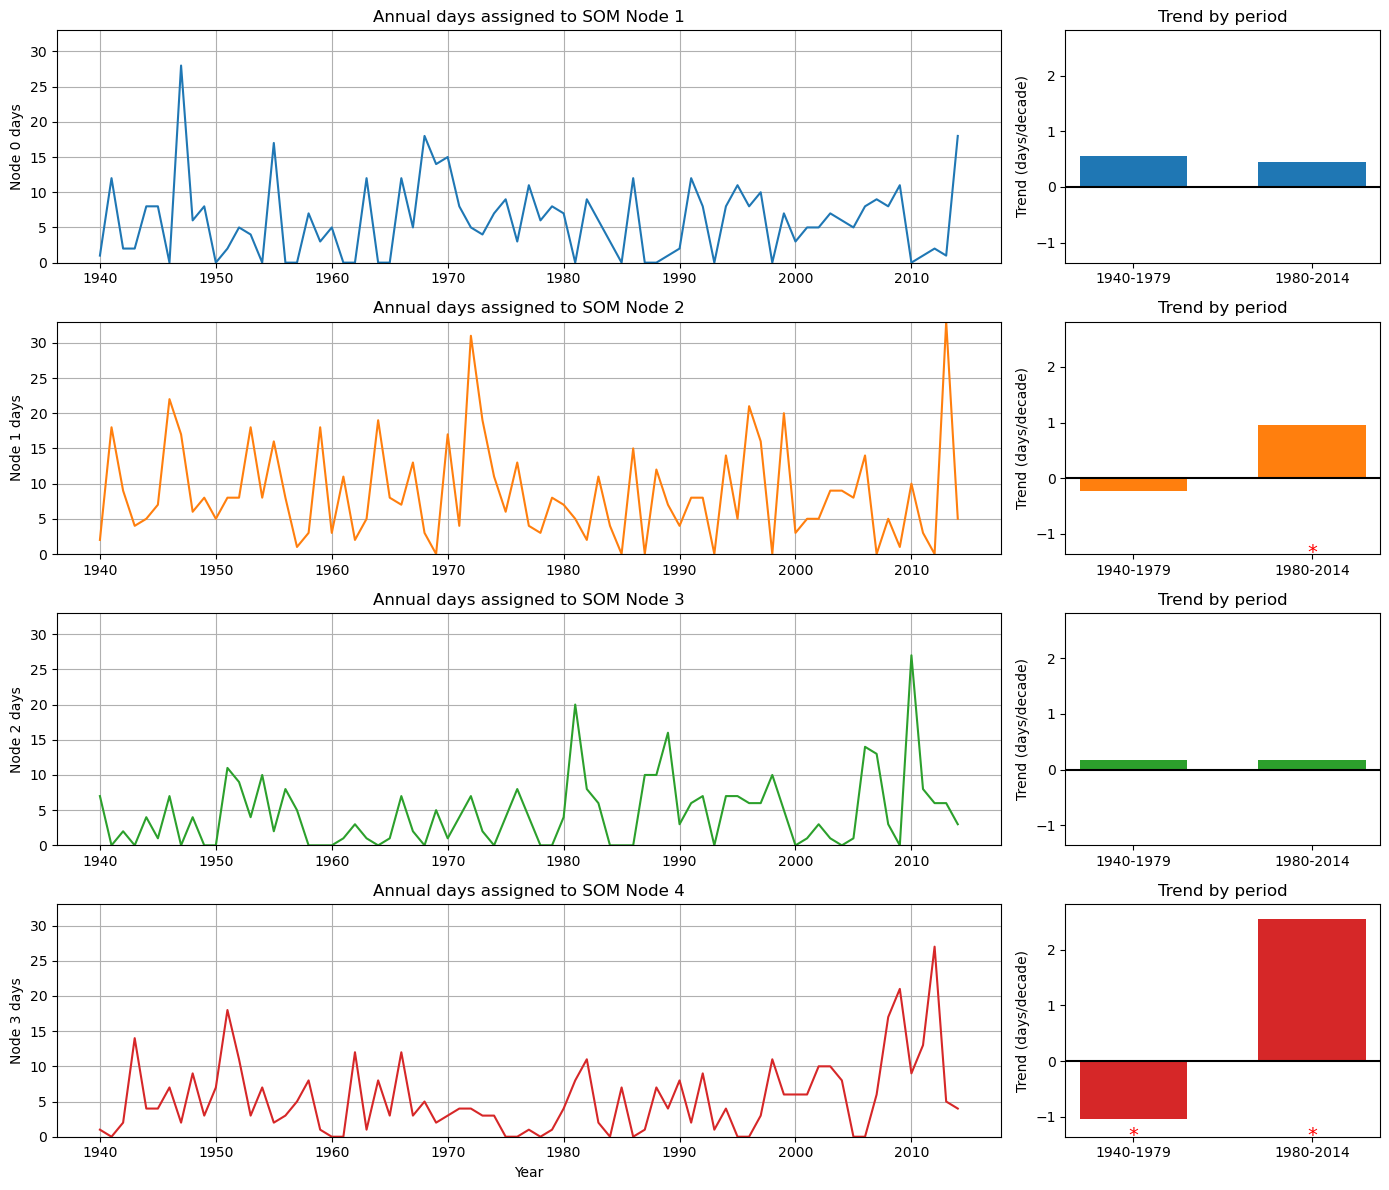

Trend table for threshold = 0.4
Period  1940-1979  1980-2014
Node                        
0        0.562895   0.444444
1       -0.231933   0.956522
2        0.176945   0.181818
3       -1.045549   2.555556


In [18]:
#node_order = [2, 3, 1, 0]
node_order = [0,1,2,3]
y_max = annual_counts[node_order].values.max()

fig, axes = plt.subplots(4, 2, figsize=(14, 12), gridspec_kw={'width_ratios':[3, 1]})

for i, node in enumerate(node_order):
    # Left column: line plot
    ax_line = axes[i, 0]
    ax_line.plot(annual_counts.index, annual_counts[node], color=f"C{i}", label=f"Node {node}")
    ax_line.set_ylabel(f"Node {node} days")
    ax_line.set_ylim(0, y_max)
    ax_line.grid(True)
    ax_line.set_title(f"Annual days assigned to SOM Node {i+1}")
    
    # Right column: bar chart
    ax_bar = axes[i, 1]
    trends_node = trend_table_pivot.loc[node]
    sig_node = sig_table_pivot.loc[node]
    periods_list = trends_node.index
    values = trends_node.values
    
    bars = ax_bar.bar(range(len(periods_list)), values, color=f"C{i}", width=0.6)
    ax_bar.set_xticks(range(len(periods_list)))
    ax_bar.set_xticklabels(periods_list)
    ax_bar.set_ylabel("Trend (days/decade)")
    ax_bar.set_ylim(trend_table_pivot.values.min()*1.3, trend_table_pivot.values.max()*1.1)
    ax_bar.set_title("Trend by period")
    ax_bar.axhline(0, c="k", lw=1.5)
    
    # Add stars for significance
    for j, bar in enumerate(bars):
        if sig_node.iloc[j]:
            ax_bar.text(bar.get_x() + bar.get_width()/2, -1.5,
                        "*", ha='center', va='bottom', fontsize=14, color='red')

axes[-1, 0].set_xlabel("Year")
plt.tight_layout()
plt.show()
print(f"Trend table for threshold = {threshold}")
print(trend_table_pivot)

/tmp/ipykernel_2106/3862250650.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # leave room on right for colorbar and top for suptitle


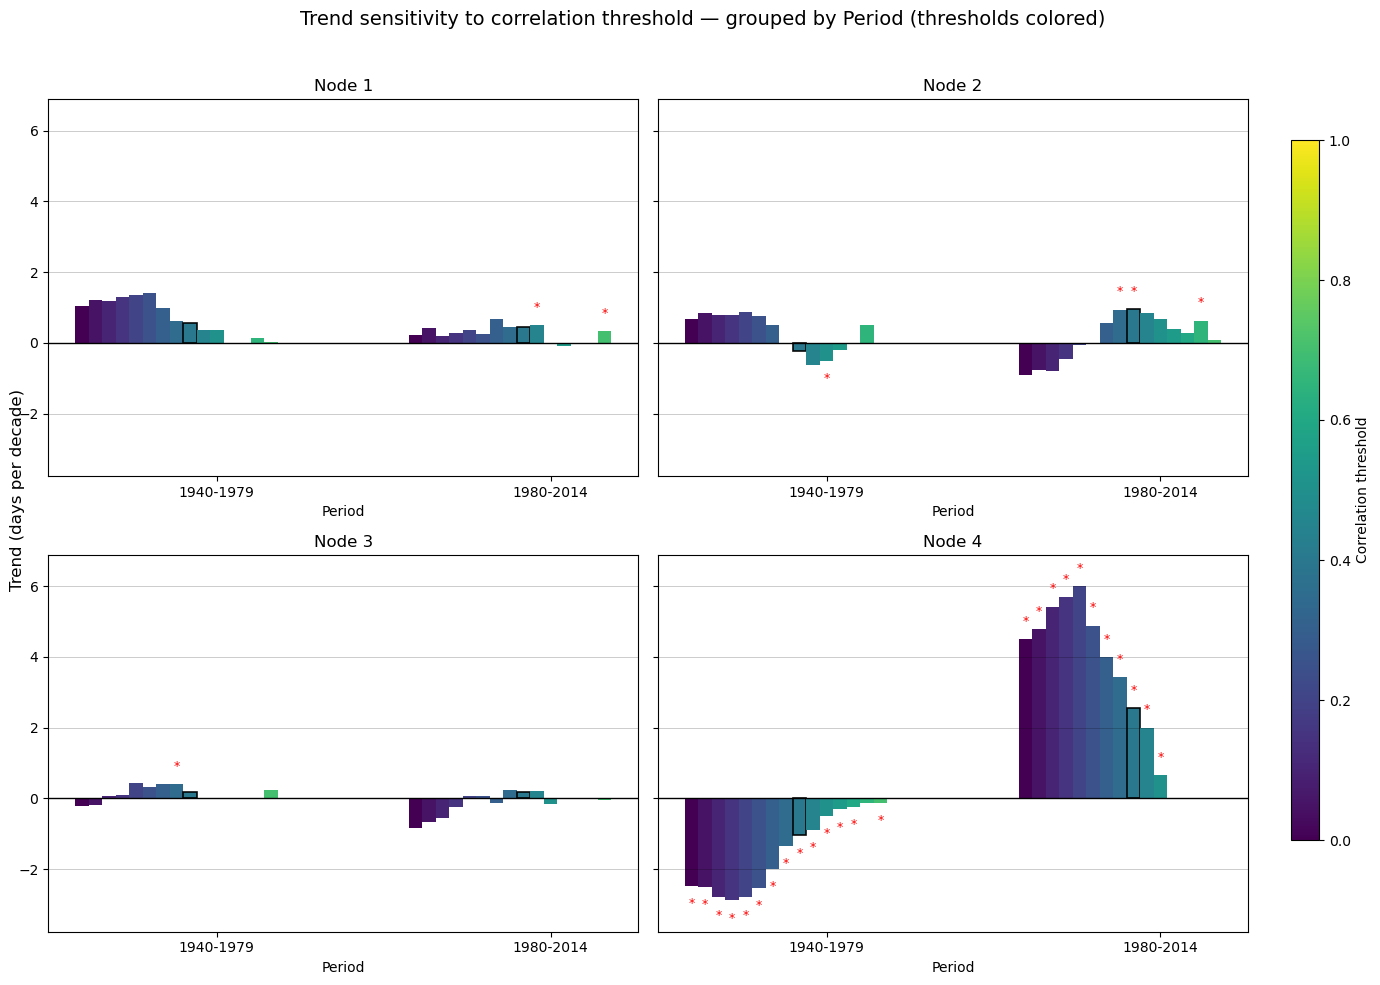

In [21]:
# ---- parameters you can change ----
thr_start = 0.0
thr_stop  = 1.0
thr_step  = 0.05   # set to 0.5 for only [0,0.5,1.0]
window = 5         # smoothing window used earlier
periods = { 
    "1940-1979": (1940, 1979),
    "1980-2014": (1980, 2014)
}
#node_order = [2, 3, 1, 0]   # preserve your plotting order
node_order = [0,1,2,3]
# -----------------------------------

thresholds = np.arange(thr_start, thr_stop + 1e-9, thr_step)
period_names = list(periods.keys())

# allocate storage: dict[node][period] -> arrays over thresholds
nodes = np.unique(best_node_idx)  # fallback; we'll ensure integer nodes later
# to be robust in case some nodes are missing in best_node_idx
nodes = np.unique(np.concatenate((nodes, np.array(node_order))))  # include requested order

# prepare results containers
results = {
    node: { pname: {"slope": [], "sig": []} for pname in period_names }
    for node in nodes
}

for thr in thresholds:
    # apply threshold: set node to NaN if corr < thr
    best_node_idx_filtered = np.where(best_node_corr >= thr, best_node_idx, np.nan)
    # build dataframe as in your snippet
    best_nodes_list = list(zip(best_node_idx_filtered, best_node_corr))
    best_nodes_idx, best_node_corr_vals = zip(*best_nodes_list)
    df = pd.DataFrame({
        "time": time_array,
        "best_node": best_nodes_idx,
        "corr": best_node_corr_vals
    })
    df_valid = df.dropna(subset=["best_node"]).copy()
    if len(df_valid) == 0:
        # no data for this threshold: append NaN/False
        for node in nodes:
            for pname in period_names:
                results[node][pname]["slope"].append(np.nan)
                results[node][pname]["sig"].append(False)
        continue

    df_valid["best_node"] = df_valid["best_node"].astype(int)
    df_valid["year"] = df_valid["time"].dt.year

    # count days per node per year
    annual_counts = df_valid.groupby(["year", "best_node"]).size().unstack(fill_value=0)

    # ensure all nodes appear as columns (so indexing later is stable)
    for n in nodes:
        if n not in annual_counts.columns:
            annual_counts[n] = 0
    annual_counts = annual_counts.sort_index(axis=1)

    # smooth
    annual_counts_smoothed = annual_counts.rolling(window=window, center=True, min_periods=1).mean()

    # compute trends for each node & period
    for node in nodes:
        for period_name, (start_year, end_year) in periods.items():
            # select series for this period and node
            try:
                df_period = annual_counts_smoothed.loc[
                    (annual_counts_smoothed.index >= start_year) &
                    (annual_counts_smoothed.index <= end_year),
                    node
                ]
            except KeyError:
                df_period = pd.Series(dtype=float)

            y = df_period.values
            x = df_period.index.values

            if len(y) > 0 and np.all(np.isfinite(y)) and len(y) >= 3:
                # theilslopes expects x increasing; our x is years (ints)
                slope, intercept, lo_slope, hi_slope = theilslopes(y, x, 0.90)
                slope_decade = slope * 10.0  # days per decade
                try:
                    mk_result = mk.original_test(y)
                    sig = mk_result.p < 0.05
                except Exception:
                    # if mk fails (e.g. constant series), mark not significant
                    sig = False
            else:
                slope_decade = np.nan
                sig = False

            results[node][period_name]["slope"].append(slope_decade)
            results[node][period_name]["sig"].append(bool(sig))

# Convert results into arrays for plotting
# --- plotting grouped by period (assumes results, thresholds, period_names, node_order exist) ---
n_thresh = len(thresholds)
n_periods = len(period_names)

# compute global y-limits across all nodes & periods (ignore NaNs)
all_slopes = []
for node in node_order:
    for pname in period_names:
        all_slopes.extend(results[node][pname]["slope"])
all_slopes = np.array([v for v in all_slopes if (v is not None and not np.isnan(v))], dtype=float)

if all_slopes.size == 0:
    global_ymin, global_ymax = -1.0, 1.0
else:
    global_ymin = all_slopes.min()
    global_ymax = all_slopes.max()
    pad = max(0.1 * (global_ymax - global_ymin), 0.2)
    global_ymin -= pad
    global_ymax += pad

# colormap for thresholds and shared ScalarMappable for colorbar
cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=thresholds.min(), vmax=thresholds.max())
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

# plotting cluster geometry (bars grouped by period, bars within a group = thresholds)
total_width = 0.85
width = total_width / n_thresh
offsets = (np.arange(n_thresh) - (n_thresh - 1) / 2.0) * width
x = np.arange(n_periods)

for ax, node in zip(axes, node_order):
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax.grid(axis='y', color='black', linestyle='-', linewidth=0.7, alpha=0.2)

    # draw bars: iterate thresholds and draw their bars across periods
    for k, thr in enumerate(thresholds):
        color = cmap(norm(thr))
        xpos = x + offsets[k]

        slopes_k = [ results[node][pname]["slope"][k] for pname in period_names ]
        sigs_k   = [ results[node][pname]["sig"][k]   for pname in period_names ]
        slopes_k = np.array(slopes_k, dtype=float)

        bars = ax.bar(xpos, slopes_k, width=width, color=color, edgecolor='none', alpha=0.95)

        edge_col = 'black' if np.isclose(thr, 0.4) else 'none'
        lw = 1.2 if np.isclose(thr, 0.4) else 0.0
        bars = ax.bar(xpos, slopes_k, width=width, color=color,
                  edgecolor=edge_col, linewidth=lw, alpha=0.95)
        
        # annotate significance stars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if np.isnan(height):
                continue
            if sigs_k[j]:
                if height >= 0:
                    txt_y = height + 0.03 * (global_ymax - global_ymin)
                    va = "bottom"
                else:
                    txt_y = height - 0.03 * (global_ymax - global_ymin)
                    va = "top"
                ax.text(bar.get_x() + bar.get_width()/2, txt_y, "*",
                        ha="center", va=va, color="red", fontsize=9)
    
    ax.set_xticks(x)
    ax.set_xticklabels(period_names, rotation=0)
    ax.set_xlabel("Period")
    ax.set_title(f"Node {node_order.index(node) + 1}")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylim(global_ymin, global_ymax)

# overall y label on the left middle
fig.text(0.005, 0.5, "Trend (days per decade)", va='center', rotation='vertical', fontsize=12)

# shared colorbar (on the right)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Correlation threshold")

plt.suptitle("Trend sensitivity to correlation threshold — grouped by Period (thresholds colored)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # leave room on right for colorbar and top for suptitle
plt.show()
